## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [56]:
# from <TC_Env> import <TicTacToe> - import your class from environment file
from TCGame_Env import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

In [57]:
env = TicTacToe()
curr_state = env.state
print(curr_state)
curr_action = random.choice(list(env.action_space(curr_state)[0]))

print(curr_action)

first_state, reward, terminated = env.step(curr_state, curr_action)
print(first_state, reward, terminated)

print(env.state_transition(curr_state, curr_action))
#print(state1,action1)

[nan, nan, nan, nan, nan, nan, nan, nan, nan]
(8, 9)
[nan, 2, nan, nan, nan, nan, nan, nan, 9] -1 False
[nan, 2, nan, nan, nan, nan, nan, nan, 9]


In [58]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [59]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [60]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [61]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy

def epsilon_greedy(state, time):
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*time)
    
    z = np.random.random()
        
    if z > epsilon:
        state_key = Q_state(state)
        action = max(Q_dict[state_key],key=Q_dict[state_key].get)   #Exploitation: this gets the action corresponding to max q-value of current state
    else:
        action = random.choice(list(env.action_space(state)[0]))    #Exploration: randomly choosing and action
    
    return action

#### Tracking the state-action pairs for checking convergence - write your code here

In [62]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track =collections.defaultdict(dict)  
  
rewards_tracked = [] 

In [63]:
# Initialising states to be tracked
def initialise_tracking_states():
    Sample_Qvalues = [('x-x-x-x-x-x-x-x-x',(6,3)),('x-x-x-x-x-x-x-x-x',(2,9)),
                       ('x-3-x-x-1-x-x-x-x',(7,5)),('x-x-x-x-x-x-x-x-x',(7,6))]    #select some 4 Q-values
    for q_values in Sample_Qvalues:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []

In [64]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [65]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [66]:
initialise_tracking_states()

#### Define hyperparameters  ---write your code here

In [67]:
EPISODES = 300000
LR = 0.01                   # learning rate
GAMMA = 0.91                # discount factor

max_epsilon = 1.0
min_epsilon = 0.001
decay_rate = 0.001        # epsilon decay rate
threshold = 2000       # no of episodes after which states_tracked wwill be saved
policy_threshold = 3000   # no of episodes after which Q dictionary/table will be saved


STEPS = 30


### Q-update loop (Q-Learning) ---write your code here 

In [68]:
import time
start_time = time.time()

for episode in range(EPISODES):
    ##### Start writing your code from the next line
    
    
    GameEnded = False
    time_step = 0
    reward = None
    total_reward = 0
    
    env = TicTacToe()  #creating an instance of the class
    curr_state = env.state    
    add_to_dict(curr_state)  # adding the current state to dictionary
    #print(curr_state)
    while time_step < STEPS and not GameEnded:  #the episode will run only for a few steps and not infinitely
        
        
        curr_state_edt = Q_state(curr_state)
        curr_action = epsilon_greedy(curr_state, episode)   # applying epsilon_greedy method
        next_state, reward, GameEnded = env.step(curr_state, curr_action) # getting reward
        next_state_edt = Q_state(next_state)
        add_to_dict(next_state)
        
        # UPDATE RULE
        if GameEnded != True:
            max_next_value = max(Q_dict[next_state_edt],key=Q_dict[next_state_edt].get) #this gets the action corresponding to max q-value of next state
            Q_dict[curr_state_edt][curr_action] += LR * ((reward + (GAMMA*(Q_dict[next_state_edt][max_next_value])))
                                                      - Q_dict[curr_state_edt][curr_action] ) 
        else:
            Q_dict[curr_state_edt][curr_action] += LR * ((reward - Q_dict[curr_state_edt][curr_action]))

        
        curr_state = next_state
        
        total_reward += reward
        
        time_step += 1
        

         #TRACKING REWARDS
        rewards_tracked.append([episode,time_step,reward])


        if ((episode+1) % threshold) == 0:   
            save_obj(rewards_tracked,'Rewards')   

         #TRACKING Q-VALUES
        if (episode == threshold-1):        
            initialise_tracking_states()

        if ((episode+1) % threshold) == 0:   
            save_tracking_states()
            save_obj(States_track,'States_tracked')   
    
        #SAVING POLICY
        if ((episode+1)% policy_threshold ) == 0:  # Q-dict - saved
            save_obj(Q_dict,'Policy')   
        
        
    
elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')

#### Check the Q-dictionary

In [69]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -1.0704320358436228,
              (0, 3): -1.0705003584848762,
              (0, 5): -1.0704620758672485,
              (0, 7): -1.0705903873632268,
              (0, 9): -1.0705305234482738,
              (1, 1): -1.0705105541538902,
              (1, 3): -1.0705659610430962,
              (1, 5): -1.0704749127858584,
              (1, 7): -1.0705822101487252,
              (1, 9): -1.0704316019120037,
              (2, 1): -1.0704727447293079,
              (2, 3): -1.0704791203529853,
              (2, 5): -1.0704905903366577,
              (2, 7): -1.0705922314945022,
              (2, 9): -1.0704824986690056,
              (3, 1): -1.0704429396210615,
              (3, 3): -1.0704342494621744,
              (3, 5): -1.0704364135701303,
              (3, 7): -1.0704470309849416,
              (3, 9): -1.0705329538618173,
              (4, 1): -1.0704336246352135,
              (4, 3): -1.0705141972770615,
              (

In [70]:
len(Q_dict)

584626

In [71]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated

#### Check the states tracked for Q-values convergence
(non-evaluative)

<function matplotlib.pyplot.show(*args, **kw)>

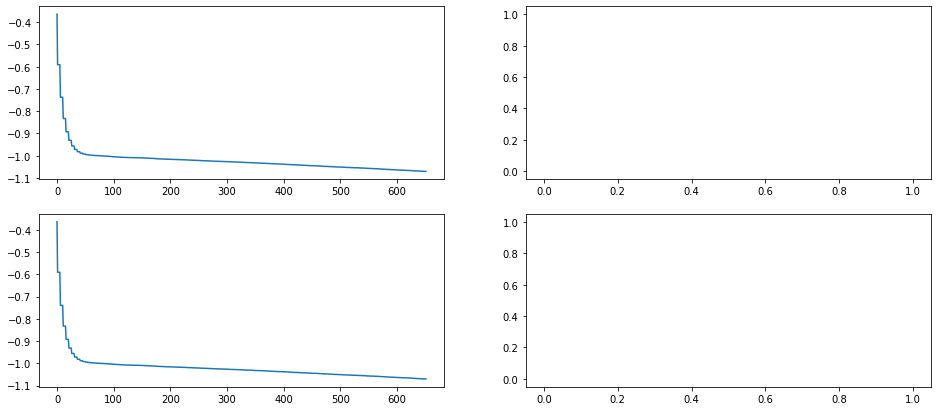

In [72]:
plt.figure(0, figsize=(16,7))

x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(6,3)])))
plt.subplot(221)
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(6,3)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-3-x-x-1-x-x-x-x'][(7,5)])))
plt.subplot(222)
plt.plot(x_axis,np.asarray(States_track['x-3-x-x-1-x-x-x-x'][(7,5)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(2,9)])))
plt.subplot(223)
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(2,9)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(7,6)])))
plt.subplot(224)
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(7,6)]))
plt.show




### Epsilon - decay check

In [73]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

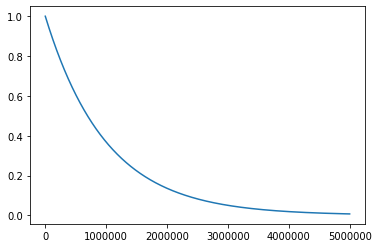

In [74]:
plt.plot(time, epsilon)
plt.show()